In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
from scipy.integrate import quad as quad
import pandas as pd
from scipy.integrate import nquad as nquad

In [2]:
#useful functions

import quadpy
scheme = quadpy.e2r2.get_good_scheme(7)

def Gaussian(x):
    return np.exp(-.5*x**2-.5*np.log(2*np.pi))

def sigm(x,beta=1):   #softmax
    x=x-np.max(x,axis=1).reshape(-1,1)
    P=np.exp(beta*x)
   
    
    return (P.T/np.sum(P,1)).T

In [3]:
#parameters
σ=.5    #token variance
λ=.01   #l_2 regularization

A=np.array([[.6,.4],[.4,.6]])

In [25]:
ρxx=σ**2*np.eye(2)   #ρΣ

In [26]:
ρ=1*σ**2
ω=.3                #positional/semantic paramter

### MSE of purely positional attention

In [28]:
def integrand_What(xx,coordinates=None,omega=ω):
    x,y=xx[0]*np.sqrt(ρ),xx[1]*np.sqrt(ρ)
    result=[]
    for i in range(len(x)):
        xy=np.array((x[i],y[i])).reshape(2,1)
        xy=sigm(xy@xy.T)
        result.append(xy)
    result=np.array(result)
    return np.moveaxis(result,[0,1,2],[-1,0,1])

def What(): #trained linear model
    return (ω*A+(1-ω)*scheme.integrate(lambda x: integrand_What(np.sqrt(2)*x,omega=ω))/np.pi)@ρxx.T@np.linalg.inv(ρxx)

def integrand_mse_lin1(xx,omega=ω):
    
    x,y=xx[0]*np.sqrt(ρ),xx[1]*np.sqrt(ρ)
    result=[]
    for i in range(len(x)):
        xy=np.array((x[i],y[i])).reshape(2,1)
        xy=(1-ω)*sigm(xy@xy.T)+ω*A
        result.append(np.trace(xy@ρxx@xy.T))
    
    return result

def integrand_mse_lin2(xx,What,omega=ω):
    #used for teacher with \rho, \theta
   
    x,y=xx[0]*np.sqrt(ρ),xx[1]*np.sqrt(ρ)
    result=[]
    for i in range(len(x)):
        xy=np.array((x[i],y[i])).reshape(2,1)
        xy=(1-ω)*sigm(xy@xy.T)+ω*A
        result.append(np.trace(What@ρxx@xy.T))
    
    return result

def mse_lin():
    W=What()
    scheme_lin= quadpy.e2r2.get_good_scheme(11)
    term1=scheme_lin.integrate(lambda x: integrand_mse_lin1(np.sqrt(2)*x,omega=ω))/np.pi
    term2=scheme_lin.integrate(lambda x: integrand_mse_lin2(np.sqrt(2)*x,W,omega=ω))/np.pi
    term3=np.trace(W@ρxx@W)
    
    return term3+term1-2*term2
    




In [31]:
print("MSE of purely attentional model:",mse_lin())

MSE of purely attentional model: 0.00398091773693432


### MSE of dot-product attention

In [48]:
def update_overlaps(qhat,mhat,Vhat,θhat,α):
    lamb=λ    
    q=(qhat*σ**2+mhat**2+θhat**2*σ**2*ρ)/(lamb+Vhat*σ**2)**2*σ**2
    V=1/(lamb+Vhat*σ**2)*σ**2
    m=(mhat)/(lamb+Vhat*σ**2)
    θ=σ**2*(θhat*ρ)/(lamb+Vhat*σ**2)
    return q,m,V,θ
    

In [49]:
def Moreau(X,q,m,V,θ,ξ1,ξ2,y1,y2, full=False):   #Moreau enveloppe
    
    x,y=X    

    termx=(x-np.sqrt(q)*ξ1-m)**2/V
    termy=(y-np.sqrt(q)*ξ2+m)**2/V
    
    xy=np.array((x,y)).reshape(2,1)
    xy=sigm(xy@xy.T)
    
    Vstar=(ρ-θ**2/q)**.5
    
    Y=np.array([Vstar*y1+θ/q**.5*ξ1,Vstar*y2+θ/q**.5*ξ2]).reshape(2,1)
    Y=sigm(Y@Y.T)*(1-ω)+ω*A
    
    term_activ1=np.trace(xy@ρxx@xy.T)
    term_activ2=-2*np.trace(Y@ρxξ.T@xy.T)
    if not full:
        return termx+termy+term_activ1+term_activ2
    elif full==True:
        return termx+termy+term_activ1+term_activ2+np.trace(Y@ρξξ@Y.T)
    elif full==None:
        return np.trace(Y@ρξξ@Y.T)

def prox(q,m,V,θ,ξ1,ξ2,y1,y2,plot=True):   #computes resolvent
    res=[]
    for i in range(len(y1)):
        Vstar=(ρ-θ**2/q)**.5
        init=[0,0]
        res.append(optimize.minimize(lambda x: Moreau(x,q,m,V,θ,ξ1,ξ2,y1[i],y2[i]),init).x)
        
    res=np.array(res)
    return res[:,0], res[:,1]
    


In [50]:
def int_mhat(Y,ξ,q,m,V,θ):
    x,y=prox(q,m,V,θ,ξ[0],ξ[1],Y[0],Y[1])
    return ((x-np.sqrt(q)*ξ[0]-m)-(y-np.sqrt(q)*ξ[1]+m))/V

def int_Vhat(Y,ξ,q,m,V,θ):
    x,y=prox(q,m,V,θ,ξ[0],ξ[1],Y[0],Y[1])
    
    return  -((x-np.sqrt(q)*ξ[0]-m)*ξ[0]+(y-np.sqrt(q)*ξ[1]+m)*ξ[1])/V/np.sqrt(q)

def int_qhat(Y,ξ,q,m,V,θ):
    x,y=prox(q,m,V,θ,ξ[0],ξ[1],Y[0],Y[1])
    return ((x-np.sqrt(q)*ξ[0]-m)**2+(y-np.sqrt(q)*ξ[1]+m)**2)/V**2

def int_θhat(Y,ξ,q,m,V,θ):
    x,y=prox(q,m,V,θ,ξ[0],ξ[1],Y[0],Y[1])
    Vstar=(ρ-θ**2/q)**.5
    return ((x-np.sqrt(q)*ξ[0]-m)*Y[0]/Vstar+(y-np.sqrt(q)*ξ[1]+m)*Y[1]/Vstar)/V

def intY_mhat(ξ,q,m,V,θ):
    collect=[]
    for i in range(len(ξ[0])):
        int_=scheme.integrate(lambda y: int_mhat(np.sqrt(2)*y,[ξ[0][i],ξ[1][i]],q,m,V,θ))/np.pi
        collect.append(int_)
    return np.array(collect)

def intY_qhat(ξ,q,m,V,θ):
    collect=[]
    for i in range(len(ξ[0])):
        int_=scheme.integrate(lambda y: int_qhat(np.sqrt(2)*y,[ξ[0][i],ξ[1][i]],q,m,V,θ))/np.pi
        collect.append(int_)
    return np.array(collect)

def intY_Vhat(ξ,q,m,V,θ):
    collect=[]
    for i in range(len(ξ[0])):
        int_=scheme.integrate(lambda y: int_Vhat(np.sqrt(2)*y,[ξ[0][i],ξ[1][i]],q,m,V,θ))/np.pi
        collect.append(int_)
    return np.array(collect)

def intY_θhat(ξ,q,m,V,θ):
    collect=[]
    for i in range(len(ξ[0])):
        int_=scheme.integrate(lambda y: int_θhat(np.sqrt(2)*y,[ξ[0][i],ξ[1][i]],q,m,V,θ))/np.pi
        collect.append(int_)
    return np.array(collect)


def update_mhat(α,q,m,V,θ):
    int_=scheme.integrate(lambda x: intY_mhat(np.sqrt(2)*x,q,m,V,θ))/np.pi
    mhat=α*int_
    return mhat

def update_Vhat(α,q,m,V,θ):
    int_=scheme.integrate(lambda x: intY_Vhat(np.sqrt(2)*x,q,m,V,θ))/np.pi
    Vhat=α*int_
    return Vhat

def update_qhat(α,q,m,V,θ):
    int_=scheme.integrate(lambda x: intY_qhat(np.sqrt(2)*x,q,m,V,θ))/np.pi#np.sqrt(np.pi)
    qhat=α*int_
    return qhat

def update_θhat(α,q,m,V,θ):
    int_=scheme.integrate(lambda x: intY_θhat(np.sqrt(2)*x,q,m,V,θ))/np.pi
    θhat=α*int_
    return θhat


def update_hat_overlaps(α,q,m,V,θ):
    qhat=update_qhat(α,q,m,V,θ)
    mhat=update_mhat(α,q,m,V,θ)
    θhat=update_θhat(α,q,m,V,θ)
    Vhat=update_Vhat(α,q,m,V,θ)+θ*θhat/q
    
    return qhat,mhat,Vhat,θhat
    

In [51]:
damping=0.8
def damp(new, old):
        return (1-damping) * new + damping * old

In [52]:
#Computes the MSE

def integrand_mse_2(xx,q,m,teacher=False):
    #used for teacher with \rho, \theta
    if not teacher:
        ρ_=ρxx
        x,y=xx[0]*np.sqrt(q)+m,xx[1]*np.sqrt(q)-m
        result=[]
        for i in range(len(x)):
            xy=np.array((x[i],y[i])).reshape(2,1)
            xy=sigm(xy@xy.T)
            result.append(np.trace(xy@ρ_@xy.T))
    else:
        ρ_=ρxx
        x,y=xx[0]*np.sqrt(ρ),xx[1]*np.sqrt(ρ)
        result=[]
        for i in range(len(x)):
            xy=np.array((x[i],y[i])).reshape(2,1)
            xy=(1-ω)*sigm(xy@xy.T)+ω*A
            result.append(np.trace(xy@ρ_@xy.T))
    
    
    
    return result

def integrand_mse_3(U,W,q,m,θ):
    Vstar=(ρ-θ**2/q)**.5
    mstar=θ/q**.5
    x1,x2=U[0]*np.sqrt(q)+m,U[1]*np.sqrt(q)-m
    y1,y2=(W[0]*Vstar+mstar*U[0]),(W[1]*Vstar+mstar*U[1])
    
    result=[]
    for i in range(len(y1)):
        xx=np.array((x1,x2)).reshape(2,1)
        xx=sigm(xx@xx.T)
        
        yy=np.array((y1[i],y2[i])).reshape(2,1)
        yy=(1-ω)*sigm(yy@yy.T)+ω*A
        
        result.append(-2*np.trace(yy@ρxx.T@xx.T))
    
    return result
    
    
def integW(U,q,m,θ):
    res=[]
    for i in range(len(U[0])):
        res.append(scheme.integrate(lambda W:integrand_mse_3([U[0][i],U[1][i]],np.sqrt(2)*W,q,m,θ))/np.pi)
    return res
    

def mse(q,m,V,θ):
    scheme = quadpy.e2r2.get_good_scheme(11)
    term1=scheme.integrate(lambda x: integrand_mse_2(np.sqrt(2)*x,ρ,0,teacher=True))/np.pi
    term2=scheme.integrate(lambda x: integrand_mse_2(np.sqrt(2)*x,q,m))/np.pi
    term3=scheme.integrate(lambda x: integW(np.sqrt(2)*x,q,m,θ))/np.pi
    return term1+term2+term3

In [53]:
def int_Phi(Y,ξ,q,m,V,θ):    
    x,y=prox(q,m,V,θ,ξ[0],ξ[1],Y[0],Y[1])
    collect=[]
    for i in range(len(x)):
        collect.append(Moreau((x[i],y[i]),q,m,V,θ,ξ[0],ξ[1],Y[0][i],Y[1][i], full=True))
    
    return  np.array(collect).flatten()

def intY_Phi(ξ,q,m,V,θ):
    collect=[]
    scheme = quadpy.e2r2.get_good_scheme(11)
    for i in range(len(ξ[0])):
        int_=scheme.integrate(lambda y: int_Phi(np.sqrt(2)*y,[ξ[0][i],ξ[1][i]],q,m,V,θ))/np.pi
        collect.append(int_)
    return np.array(collect)

def Phi(q,m,V,θ,qhat,mhat,Vhat,thetahat,alpha): #computes the training loss
    scheme = quadpy.e2r2.get_good_scheme(11)
    trace_term=.5*(Vhat*q-qhat*V)-m*mhat-θ*thetahat
    entro=.5*(qhat*σ**2+mhat**2+thetahat**2*ρ*σ**2)/(λ+Vhat*σ**2)
    int_=scheme.integrate(lambda x: intY_Phi(np.sqrt(2)*x,q,m,V,θ))/np.pi/2
    return trace_term+entro-alpha*int_
    

In [54]:
# Iterates the state evolution equations until convergence

def iterate(α,max_iter=300,tol=1e-4,verbose=True,init=[.8, .8,.1,.01]):
    last_flip=None
    q,m,V,θ=init
    assert ρ-θ**2/q>0
    qhat,mhat,Vhat,θhat=0,0,0,0
    for i in range(max_iter):
        qhat,mhat,Vhat,θhat=update_hat_overlaps(α,q,m,V,θ)
        q_tmp,m_tmp,V_tmp,θ_tmp=update_overlaps(qhat,mhat,Vhat,θhat,α)
        if max([np.abs(q_tmp-q),np.abs(m_tmp-m),np.abs(θ_tmp-θ)])<tol:
            if verbose:
                print("convcerged after {} steps".format(i))
            print("q{} m{} V{} qhat{} mhat{} Vhat{} ".format(q,m,V,qhat,mhat,Vhat))
            return q,m,V,θ,qhat,mhat,Vhat,θhat
        
        q=damp(q_tmp,q)
        m=damp(m_tmp,m)
        V=damp(V_tmp,V)
        θ=damp(θ_tmp,θ)
       
        
        if verbose:
            print("q{} m{} V{} theta{} qhat{} mhat{} Vhat{} thetahat{}".format(q,m,V,θ,qhat,mhat,Vhat,θhat))
        
    print(α, "Not converged")
    
    return q,m,V,θ,qhat,mhat,Vhat,θhat
        
        
        

In [55]:
def get_curves(alphas,verbose=True):
    results={"q":[], "m":[], "V":[], "theta":[], "mse":[],
             "alpha":[],"lambda":[],"train_loss":[]}

    
    if positional:    #positional solution
        init=[0.0206838209589,0.2,14.575,.00]
    elif positional==False:   #semantic solution
        init=[0.906838209589,0.0002,14.575,.3472]

    for α in alphas:
        print("sample complexity {} ###################################".format(α))
        q,m,V,θ,qhat,mhat,Vhat,thetahat=iterate(α=α,verbose=verbose,init=init)

        error=mse(q,m,V,θ)
        
        entro=Phi(q,m,V,θ,qhat,mhat,Vhat,thetahat,alpha=α)
        results["q"].append(q)
        results["train_loss"].append(entro)
        results["m"].append(m)
        results["V"].append(V)
        results["theta"].append(θ)
        results["mse"].append(error)
        
        results["lambda"].append(λ)
        results["alpha"].append(α)
        

    res=pd.DataFrame.from_dict(results)
    
    return res





In [56]:
alphas=np.flip(np.linspace(.1,2,10))
positional=False
res=get_curves(alphas,verbose=True)

sample complexity 2.0 ###################################
q0.7516150339383423 m-0.00010701246267709607 V14.328891097189917 theta0.30130785830106716 qhat0.00042269794929215696 mhat-2.501155470133591e-05 Vhat0.034937490034936444 thetahat0.03529234793560631
q0.6276703472286059 m-1.3254847746742643e-05 V13.603884265264028 theta0.2662336017214443 qhat0.0005974509738765841 mhat8.449655439273924e-06 Vhat0.053424268077700135 thetahat0.04706212952493184
q0.5246834198465279 m-1.4613164616240585e-06 V12.796292781255113 theta0.23495885769936173 qhat0.0007044156857100166 mhat1.1946779809866298e-06 Vhat0.0645377009651446 thetahat0.04593799780768082
q0.439491479453376 m-1.3308824663871681e-07 V12.131372707367168 theta0.2083282768790836 qhat0.0006383237265286778 mhat1.3671856063550803e-07 Vhat0.06557775279448037 thetahat0.04299377520789166
q0.3696241485491141 m-7.578455239868044e-09 V11.625072650382661 theta0.18655144453179767 qhat0.0005490412505163346 mhat1.2876752122233191e-08 Vhat0.0641680509901346

q0.11420170807251895 m-2.1721579216520872e-09 V12.357043013721503 theta0.1583559767426509 qhat8.93207701040498e-05 mhat4.61834279994246e-10 Vhat0.04109484456260244 thetahat0.05144029322690234
q0.11419658143484646 m-7.604865053545017e-09 V12.351324605787108 theta0.15840460744521395 qhat8.922478880541393e-05 mhat-5.948779299781095e-10 Vhat0.04111319111418997 thetahat0.051457926251823737
q0.11419295224516937 m-1.055501142725402e-08 V12.346260685376881 theta0.15844669391673108 qhat8.914287158882993e-05 mhat-4.5342341081546935e-10 Vhat0.04112928720188762 thetahat0.05147330047480065
q0.11419046686409955 m7.881367397212197e-09 V12.341783805537817 theta0.15848310344822464 qhat8.907294837755255e-05 mhat1.6558686731260678e-09 Vhat0.0411433007584857 thetahat0.05148663874598129
q0.11418885077139175 m-1.590990277239581e-08 V12.337831683300436 theta0.15851459370725615 qhat8.901325946722156e-05 mhat-2.253586559992654e-09 Vhat0.041155503785973616 thetahat0.05149821656434206
q0.11418789330774856 m1.474

q0.10638914747284435 m3.1525875988730876e-08 V13.644141628539675 theta0.1489881499856513 qhat8.833396386544192e-05 mhat1.9954916104798942e-09 Vhat0.03361109285015036 thetahat0.04411128334103136
q0.10632582588842332 m4.055926121666687e-09 V13.63042386309906 theta0.1491658243545431 qhat8.801430629293682e-05 mhat-1.9487949200892042e-09 Vhat0.03366182538817453 thetahat0.04416071272334606
q0.10627461750640083 m8.14048128553804e-09 V13.617795034150795 theta0.14931910396917725 qhat8.77438149515235e-05 mhat4.5106134850123254e-10 Vhat0.03370674304347912 thetahat0.04420406316966909
q0.10623394779047204 m-2.563222105141667e-09 V13.606304519176627 theta0.14945173557498947 qhat8.751523036877839e-05 mhat-8.365945735538245e-10 Vhat0.03374445026022595 thetahat0.04424143783938107
q0.10620149941277786 m2.400092436839077e-08 V13.595869235868959 theta0.14956632173314233 qhat8.732088950483662e-05 mhat2.402543145456294e-09 Vhat0.03377826094216654 thetahat0.044274235931576235
q0.10617569231464946 m-9.8840856

q0.0998008938526551 m-3.189864849033269e-09 V15.14940735656377 theta0.13553143862539302 qhat9.05529993779516e-05 mhat-2.4201166963188107e-11 Vhat0.026296917268172786 thetahat0.036768826403186614
q0.09932583986246958 m3.104908255277993e-09 V15.130397027979885 theta0.1362073467215742 qhat8.930971011710376e-05 mhat4.696979600211013e-10 Vhat0.026425957976644664 thetahat0.03690917944243829
q0.09893358200863558 m-5.493004074732126e-09 V15.110276443304125 theta0.1367914266130088 qhat8.826426919523442e-05 mhat-6.634264767233688e-10 Vhat0.026534510921468277 thetahat0.03702718619043649
q0.09861034446476372 m-5.109218074062527e-09 V15.089852212685564 theta0.1372957946699921 qhat8.739227493735132e-05 mhat-5.9535532553345e-11 Vhat0.02663044062798471 thetahat0.03713001743493117
q0.09834433915616296 m2.3835261944394308e-07 V15.069771581670574 theta0.13773092868131304 qhat8.666035927097145e-05 mhat2.0217553774941678e-08 Vhat0.026713592751580716 thetahat0.03721856999294655
q0.0981288152893774 m1.066370

q0.10098009634391379 m8.38619128971376e-09 V16.532442034287385 theta0.11295863851683384 qhat0.00010303108406517516 mhat7.949743227790963e-10 Vhat0.017295970889624104 thetahat0.027284893603830823
q0.09847362156183942 m1.136372048824611e-08 V16.70002093725067 theta0.11453636872387746 qhat9.953134597943139e-05 mhat3.3496526127434593e-10 Vhat0.017569408466734254 thetahat0.02782842789727913
q0.09649104895126986 m9.117037814246054e-09 V16.812622732054482 theta0.11608535074709503 qhat9.647227101562085e-05 mhat1.8870835379941072e-12 Vhat0.01792725872224637 thetahat0.028333677104999275
q0.09490017982684784 m1.245373234092505e-08 V16.87956697881856 theta0.11755546816520128 qhat9.38368482164602e-05 mhat3.7615899143020233e-10 Vhat0.01831806966665574 thetahat0.02879418248873471
q0.0936068314520439 m-1.4326515209608031e-09 V16.910606071191058 theta0.11891691233120817 qhat9.155985107468155e-05 mhat-8.362046017212649e-10 Vhat0.01870348961320885 thetahat0.029202095286810184
q0.09255117941441518 m1.1827

q0.2120325032946102 m9.67651825017433e-10 V14.427203594445736 theta0.1208201683228332 qhat0.00015949484819301568 mhat1.6655848133970154e-09 Vhat0.025192508831919886 thetahat0.01922502445961797
q0.18144287178257812 m-3.9347878881589885e-09 V14.756998966985929 theta0.1118858501516292 qhat0.00013886946852659213 mhat-3.66140247113205e-10 Vhat0.022203830236021502 thetahat0.018946932741840734
q0.1572679303903085 m-9.661539514237144e-09 V15.174232858697767 theta0.10535359387263094 qhat0.000125001745962366 mhat-4.834088396509003e-10 Vhat0.01937125217386978 thetahat0.01881464740006572
q0.13845908394949819 m-1.613912207736388e-08 V15.658407455799626 theta0.10082933267504288 qhat0.00011578356181747182 mhat-5.974594967229908e-10 Vhat0.016833986044433813 thetahat0.018808022780250344
q0.12406598277902198 m-1.597593070021238e-08 V16.183392695110953 theta0.09795431912563816 qhat0.00010947764362977424 mhat-2.09523677177324e-10 Vhat0.014694620741175704 thetahat0.018914332926780582
q0.11320830303293669 m

q0.07711288394178009 m7.533632610481408e-09 V18.130296378796885 theta0.11508940412647617 qhat7.318089262074354e-05 mhat5.567156338628266e-10 Vhat0.015259774656193732 thetahat0.025480064694443073
q0.07711424192547645 m5.20741126145068e-09 V18.122866711199986 theta0.11512974003637375 qhat7.316529566229464e-05 mhat-5.661637938060359e-11 Vhat0.015269541693038603 thetahat0.025488341424257193
q0.07711583450421637 m-1.3112152475145028e-08 V18.11627061628889 theta0.11516515861242653 qhat7.315502535291244e-05 mhat-1.1939047914868543e-09 Vhat0.015279507395370446 thetahat0.02549641969180807
q0.07711742970281525 m-8.92094688105674e-09 V18.11049596559106 theta0.11519608112324807 qhat7.314358422171075e-05 mhat1.0841630968185717e-10 Vhat0.015287114002188882 thetahat0.02550278934076206
q0.07711885251389679 m1.2858161885258512e-08 V18.10546582061293 theta0.11522294738270988 qhat7.313241001959662e-05 mhat1.3819835289283046e-09 Vhat0.0152933873636836 thetahat0.025508036675132996
q0.07712005265492179 m2.9

q0.0656102489417809 m-9.93109596919346e-10 V21.962659287014286 theta0.09009004873642544 qhat6.660865803171677e-05 mhat-7.977728030366527e-11 Vhat0.006040205296888732 thetahat0.01692579200004133
q0.0655282867449582 m1.1511153868815866e-09 V21.901052298433832 theta0.09052058266720173 qhat6.646203710315872e-05 mhat1.123087517878185e-10 Vhat0.006179512704033753 thetahat0.017038895143039134
q0.06546182257338234 m5.220197935971053e-10 V21.839294834431513 theta0.0909277492782509 qhat6.633952567606433e-05 mhat-2.3091169239700466e-11 Vhat0.00631288107103764 thetahat0.017146217094860933
q0.06540788135105312 m-9.255502159161045e-09 V21.777918431164686 theta0.091313180221327 qhat6.62230732705798e-05 mhat-5.615440124938499e-10 Vhat0.006441613786984796 thetahat0.017249326357999133
q0.0653646539650128 m1.0018446203365635e-09 V21.7173485698943 theta0.09167792734404337 qhat6.612146456538215e-05 mhat4.893026361643143e-10 Vhat0.00656562426821616 thetahat0.017347914513075345
q0.06532995639477529 m4.495593

q0.06540952548529491 m1.4869330759537058e-09 V20.702709092379 theta0.09670560080517994 qhat6.532280652891152e-05 mhat1.2967401028846474e-10 Vhat0.008353451731320159 thetahat0.018722865782367516
q0.06541229521634705 m-3.820529920974201e-09 V20.6977077493297 theta0.0967278283825495 qhat6.532175318030069e-05 mhat-3.028670866303437e-10 Vhat0.008361272532189087 thetahat0.018728722742251548
q0.06541485584702605 m9.723358444526306e-10 V20.693091783188077 theta0.09674830443348618 qhat6.532080643292854e-05 mhat2.435811539807265e-10 Vhat0.008368464184030259 thetahat0.018734113913608724
convcerged after 79 steps
q0.06541485584702605 m9.723358444526306e-10 V20.693091783188077 qhat6.531994846907207e-05 mhat1.4926349909302965e-09 Vhat0.008375096326615008 
sample complexity 0.7333333333333333 ###################################
q0.7395873229664438 m2.1074316714542255e-05 V15.447131904298622 theta0.2900118712107497 qhat0.00015498924807379088 mhat-9.170903390489833e-06 Vhat0.012810413012810027 thetahat

q0.05299038137595494 m-3.1874898346048764e-09 V25.527617091439296 theta0.06476743352025348 qhat5.499537073911863e-05 mhat3.403234665750263e-10 Vhat-0.0007013959752188159 thetahat0.010316153091671837
q0.052959369444131446 m1.4916364763136506e-09 V25.506501120435846 theta0.06496854316881592 qhat5.497769147669739e-05 mhat1.987266159282825e-10 Vhat-0.0006640494347437999 thetahat0.010348971036645796
q0.05293447073833828 m4.458213702447615e-09 V25.485131091478344 theta0.06515642890118234 qhat5.4963741453764456e-05 mhat1.6067664298452814e-10 Vhat-0.0006293802635815669 thetahat0.010379350786172085
q0.05291474116529786 m-1.940941069585268e-10 V25.463848959487205 theta0.06533177709706021 qhat5.4953320952079435e-05 mhat-1.8522727924087613e-10 Vhat-0.0005969102067923688 thetahat0.010407643688537197
q0.052899484352447824 m1.95603769034123e-09 V25.442961624782125 theta0.06549511112007053 qhat5.494635404081984e-05 mhat1.0406949459731815e-10 Vhat-0.0005669094881362892 thetahat0.010433750824537777
q0.0

q0.1299266128844595 m1.8720979179837943e-07 V19.69682371950548 theta0.06987554862555544 qhat5.0029471778743e-05 mhat-2.248087449149291e-09 Vhat0.00556150767659459 thetahat0.006103069742356194
q0.10978433023051845 m1.3092646554072544e-07 V20.297120285180057 theta0.06258951696966042 qhat4.802056101822952e-05 mhat-1.0375976649532941e-09 Vhat0.004056150087261521 thetahat0.005893900547255844
q0.09389933208929675 m1.0102975201102378e-07 V20.929493138615204 theta0.056786133239371234 qhat4.69738992833717e-05 mhat-1.977611399415767e-10 Vhat0.0026275910522980447 thetahat0.005724475966687662
q0.0814804576100227 m8.219078234480015e-08 V21.58620015387702 theta0.05219806637145083 qhat4.643384982304612e-05 mhat7.057051702947233e-11 Vhat0.0013000799042403727 thetahat0.005591336795933277
q0.07185449565544463 m6.4094741783325e-08 V22.256169786163642 theta0.04860225031061782 qhat4.6102592285263945e-05 mhat-8.310679741390813e-11 Vhat0.00010258511514129372 thetahat0.005489079205268645
q0.06445276859761932 

q0.03946317213675474 m-6.471714703741414e-07 V28.353513658308692 theta0.04011774372856235 qhat4.1047733316486746e-05 mhat-2.8909787019282614e-11 Vhat-0.004718844324068667 thetahat0.005678146154612519
q0.03946089795320778 m-5.217731900833733e-07 V28.3511158677909 theta0.0401445732961871 qhat4.1047332174763304e-05 mhat-1.780079682536296e-10 Vhat-0.004716083189476895 thetahat0.005680977574020598
q0.03946011470643328 m-5.60234207005443e-07 V28.348843171429596 theta0.04017017817448661 qhat4.1050612551575566e-05 mhat-6.299263530676383e-09 Vhat-0.004713876593552849 thetahat0.005684255407623354
q0.039460029759329475 m-3.7092272273115684e-07 V28.34667927306785 theta0.04019408800073603 qhat4.1052119757114984e-05 mhat3.4081700503677883e-09 Vhat-0.004711724031794612 thetahat0.0056870200633938875
q0.0394592663311577 m-2.4236652575486074e-07 V28.344573139756065 theta0.04021517114639806 qhat4.1049297227175814e-05 mhat2.39851104966217e-09 Vhat-0.004709388919202105 thetahat0.005688776451403734
convcerg

q0.02505652379105616 m-2.3830248611000512e-08 V29.602175755097313 theta0.019241547988520666 qhat2.647922642230946e-05 mhat-8.10663816190221e-10 Vhat-0.006354886393964541 thetahat0.0025976169012093893
q0.02502048077677109 m1.0177739979096729e-08 V29.626765140286164 theta0.019257419431920976 qhat2.6463978332725247e-05 mhat1.2296811682524785e-09 Vhat-0.006358423118038409 thetahat0.0025999428716026694
q0.02499064767041804 m-2.7796591422822237e-08 V29.646887956999812 theta0.019273550879757406 qhat2.6451305576418385e-05 mhat-1.5111819618991573e-09 Vhat-0.006360976779360311 thetahat0.0026020560407269966
q0.02496599584080474 m-1.1814411263075321e-07 V29.66334165714082 theta0.01928961084978691 qhat2.644093800133797e-05 mhat-4.032524418786505e-09 Vhat-0.006362987748317628 thetahat0.0026040228564761744
q0.024945565838984014 m-9.527602128959401e-08 V29.67675206391501 theta0.019305233319126567 qhat2.6432298433596378e-05 mhat-3.198457414059644e-11 Vhat-0.00636438755594667 thetahat0.00260578092544271

q0.008410290220840303 m-3.603255473648779e-07 V28.62608496581006 theta0.0045140368137747055 qhat9.851030364898283e-06 mhat-1.542997181253371e-08 Vhat-0.005286399804768378 thetahat0.0006198752256756281
q0.008380043353741384 m-5.077163772398397e-06 V28.664106145860295 theta0.004506381818731247 qhat9.849702945468708e-06 mhat-2.077349222163635e-07 Vhat-0.005297287047825373 thetahat0.0006212843133030211
q0.008355808371714327 m-5.052431987176418e-06 V28.695895022692987 theta0.004501405164168629 qhat9.844542326665112e-06 mhat-4.296478647470577e-08 Vhat-0.005305546026145209 thetahat0.0006219325801410186
convcerged after 39 steps
q0.008355808371714327 m-5.052431987176418e-06 V28.695895022692987 qhat9.839041126701923e-06 mhat2.1717887285001656e-08 Vhat-0.005311920654953256 


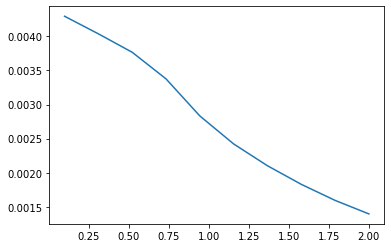

In [59]:
plt.plot(res["alpha"],res["mse"]/2)